In [1]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import json


import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [2]:
def query_prom(query, startTime, endTime, PROMETHEUS = 'http://20.71.55.156:9090/', debug=False):
    response = requests.get(PROMETHEUS + '/api/v1/query_range',
      params={'query': query,
              'start': startTime,
              'end': endTime,
              'step': '15s'})
    if debug:
        print(response.json())
    results = response.json()['data']['result']
    return results

In [3]:
from prometheus_api_client import PrometheusConnect
prom = PrometheusConnect(url ="http://20.71.55.156:9090", disable_ssl=True)

# Get the list of all the metrics that the Prometheus host scrapes
metrics = prom.all_metrics()
# import pprint
# pprint.pprint(metrics)

# We are interested resource related metrics (VM metrics)
node_metrics = [i for i in metrics if i.startswith('node_')]

print(f"By selecting VM metrics onlye, number of metrics reduce number of metrics from %i to %i" \
      %(len(metrics), len(node_metrics)))


By selecting VM metrics onlye, number of metrics reduce number of metrics from 620 to 236


In [4]:
startTime = 1619692800
endTime = 1619696520

startTime = 1620598279
endTime = 1620648679

startTime = 1621335960
endTime = 1621343220


In [5]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))


In [6]:
def caliper_df(label, startTime=startTime, endTime=endTime):
    label_data = query_prom(label, startTime, endTime, debug=False)[0]
    time = list(map(int, np.array(label_data['values'])[:,0]))
    value_t = list(map(float, np.array(label_data['values'])[:,1]))
    # transfer time from timestamp to datetime
    time_ax = []
    for each in time:
        time_ax.append(datetime.datetime.fromtimestamp(each))
    label = [0]
    for i in range(1,len(value_t)):
        if value_t[i]-value_t[i-1] != 0:
            label.append(1)
        else:
            label.append(0)
    return pd.DataFrame({'time': time_ax,'label': label})


# Caliper data for label
txn_failure = 'caliper_txn_failure'
label_data=caliper_df(txn_failure)

# query

##### OLD

In [7]:
# def query_data(metric):
#     query = 'irate('+metric+'{device="sdb",instance="nodeexporter1",job="nodeexporter"}[5m])'
#     try:
#         result = query_prom(query, startTime, endTime)[0]
#         value = list(map(float, np.array(result['values'])[:,1]))
#         label_data[metric] = value
#         return value
#     except:
#         pass
    
# for metric in tqdm(node_metrics):
#     query_data(metric)

##### New

In [8]:
queries = []
metric_names= []

# Todo get even more metrics
with open('Node Exporter Full-1622052567560.json') as json_file:
    data = json.load(json_file)
    z = 0
    for j,i in enumerate(data['panels']):
        try:
            queries.append(i['targets'][0]['expr'])
            if len(i['description']) > 0:
                metric_names.append(i['description'])
            else:
                metric_names.append("unknown_metric_"+str(z))
                z+=1
        except:
            pass

def set_query(query):
    query = query.replace('$job', 'nodeexporter')
    query = query.replace('$node', 'nodeexporter2')
    query = query.replace('$__rate_interval', '5m')
    return query

for i in queries:
    query = set_query(i)
    try:
        result = query_prom(query, startTime, endTime)[0]
    except:
        pass

In [9]:
# update on new
new_q = []
new_metric_names = []
with open('Node Exporter Full-1622052567560.json') as json_file:
    data = json.load(json_file)
#     print(len(data['panels']))
    z = 0
    m = 0
    for item in data['panels']:
        try:
            for target in item['targets']:
                
                new_q.append(target['expr'])
#                 if len(i['description']) > 0:
#                     new_metric_names.append(i['description'])
#                 else:
#                     new_metric_names.append("unknown_metric_"+str(z))
#                     z+=1
        except:
            pass
queries = new_q

In [10]:
def query_data(query, label):
    try:
        result = query_prom(query, startTime, endTime)[0]
        value = list(map(float, np.array(result['values'])[:,1]))
        label_data[label] = value
        return value
    except:
        pass

# todo get name from json
for query, metric_name in tqdm(zip(queries, metric_names)):
    query = set_query(query)
    query_data(query, metric_name)

In [11]:
# TODO Handle nan instead of fill 0
label_data = label_data.fillna(0)


<p style="color:red;">Looks like not all metrics hold data since query_prom(query, startTime, endTime)[0] is empty</p>

In [12]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))
label_data["caliper_txn_falure"] = caliper_txn_failure
label_data.head()

time  label  Busy state of all CPU cores together  \
0 2021-05-18 13:06:00      0                              6.950000   
1 2021-05-18 13:06:15      0                              7.016949   
2 2021-05-18 13:06:30      0                              7.424576   
3 2021-05-18 13:06:45      1                              8.510169   
4 2021-05-18 13:07:00      0                             10.101695   

   Busy state of all CPU cores together (5 min average)  \
0                                               4.25      
1                                               4.00      
2                                               3.75      
3                                               4.50      
4                                               7.50      

   Busy state of all CPU cores together (15 min average)  \
0                                              21.25       
1                                              21.00       
2                                              20.50       
3                                              20.50       
4                                              21.25       

   Non available RAM memory  Used Swap  Used Root FS  System uptime  \
0                 23.388541   7.983313           0.0            4.0   
1                 23.803510   8.381452           0.0            4.0   
2                 17.132260   8.986905           0.0            4.0   
3                 18.097213   9.732177           0.0            4.0   
4                 18.636683   9.976837           0.0            4.0   

   Total RootFS  ...  Basic memory usage  Basic network info per interface  \
0  1.089743e+07  ...            9.196610                         10.505085   
1  1.089745e+07  ...            9.213559                         10.644068   
2  1.089746e+07  ...            9.813559                         11.247458   
3  1.089748e+07  ...           11.227119                         13.406780   
4  1.089749e+07  ...           13.088136                         16.074576   

   Disk space used of all filesystems mounted  unknown_metric_0  \
0                                    3.467797          0.935593   
1                                    3.569492          0.932203   
2                                    3.905085          0.979661   
3                                    4.305085          1.291525   
4                                    5.718644          1.616949   

   unknown_metric_1  unknown_metric_2  unknown_metric_3  unknown_metric_4  \
0           0.00678        372.200000      1.679186e+10      1.680970e+09   
1           0.00678        371.932203      1.679186e+10      1.748369e+09   
2           0.00678        370.301695      1.679186e+10      1.618313e+09   
3           0.00678        365.959322      1.679186e+10      1.743901e+09   
4           0.00678        359.593220      1.679186e+10      1.787793e+09   

   unknown_metric_5  caliper_txn_falure  
0      2.246402e+09             12506.0  
1      2.248684e+09             12506.0  
2      1.258512e+09             12506.0  
3      1.294959e+09                 0.0  
4      1.341653e+09                 0.0  

[5 rows x 22 columns]

# Correlation
<p style="color:red;">Correlate with caliper txn falure or boolean labels?</p>

In [13]:
labels_to_correlate = label_data.drop(['label', 'caliper_txn_falure', 'time'], axis=1)

In [14]:
from scipy import stats
import pprint

correlation_txn_falure = {}
for label in labels_to_correlate.columns:
    r,p = stats.pearsonr(labels_to_correlate[label], label_data.caliper_txn_falure)
    correlation_txn_falure[label] = (p,r)


<AxesSubplot:>

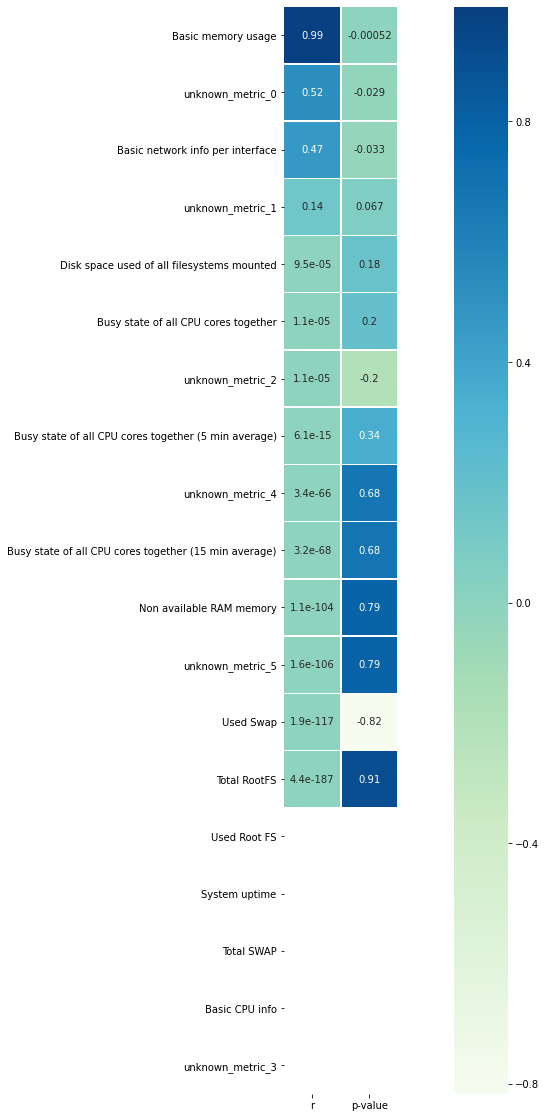

In [15]:
import seaborn as sns

txn_falure_correlation = pd.DataFrame.from_dict(correlation_txn_falure, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

plt.figure(figsize=(20,20))
sns.heatmap(txn_falure_correlation, cmap='GnBu', square=True, annot=True, linewidths=.5)

                             r   p-value
unknown_metric_1  7.282862e-01 -0.015815
Used Swap         1.167540e-01  0.071317
Total RootFS      3.736882e-02  0.094558
unknown_metric_0  3.242200e-06 -0.209555
unknown_metric_5  3.411846e-14  0.335125


<AxesSubplot:>

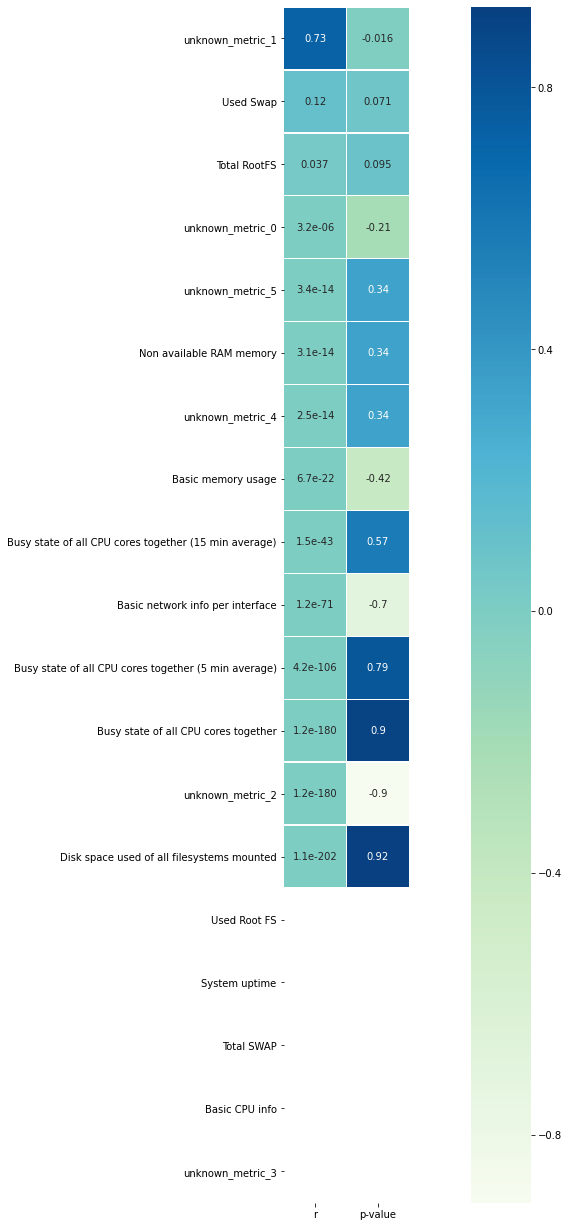

In [16]:
from scipy import stats
import pprint

correlation_txn_falure_bool = {}
for label in labels_to_correlate.columns:
    r,p = stats.pointbiserialr(labels_to_correlate[label], label_data.label)
    correlation_txn_falure_bool[label] = (p,r)
pointbiserialr = pd.DataFrame.from_dict(correlation_txn_falure_bool, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

print(pointbiserialr.head())
plt.figure(figsize=(22,22))
sns.heatmap(pointbiserialr, cmap='GnBu', square=True, annot=True, linewidths=.5)

<p style="color:red;">2 methods to calculate correlation, dont know which method is best for the data</p>

<AxesSubplot:>

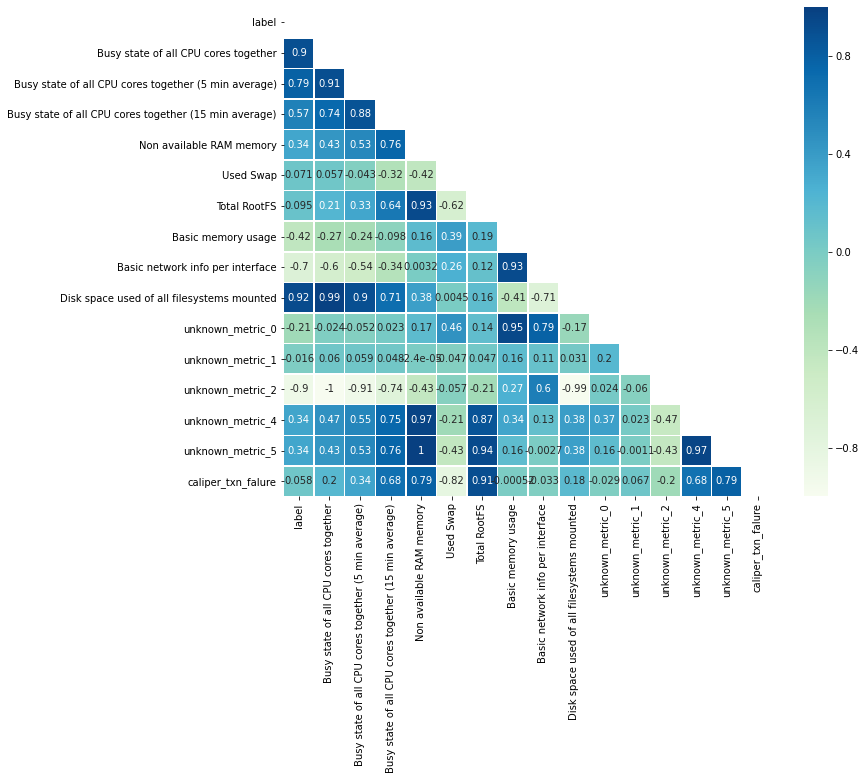

In [17]:
correlations = label_data.corr().dropna(axis=1, how='all').T.dropna(axis=1, how='all').T
# heatmap

matrix = np.triu(correlations)

plt.figure(figsize=(11,9))
sns.heatmap(correlations, cmap='GnBu', square=True, annot=True, linewidths=.5, mask=matrix)
#plt.savefig('xx.png')

In [18]:
label_data.head()

time  label  Busy state of all CPU cores together  \
0 2021-05-18 13:06:00      0                              6.950000   
1 2021-05-18 13:06:15      0                              7.016949   
2 2021-05-18 13:06:30      0                              7.424576   
3 2021-05-18 13:06:45      1                              8.510169   
4 2021-05-18 13:07:00      0                             10.101695   

   Busy state of all CPU cores together (5 min average)  \
0                                               4.25      
1                                               4.00      
2                                               3.75      
3                                               4.50      
4                                               7.50      

   Busy state of all CPU cores together (15 min average)  \
0                                              21.25       
1                                              21.00       
2                                              20.50       
3                                              20.50       
4                                              21.25       

   Non available RAM memory  Used Swap  Used Root FS  System uptime  \
0                 23.388541   7.983313           0.0            4.0   
1                 23.803510   8.381452           0.0            4.0   
2                 17.132260   8.986905           0.0            4.0   
3                 18.097213   9.732177           0.0            4.0   
4                 18.636683   9.976837           0.0            4.0   

   Total RootFS  ...  Basic memory usage  Basic network info per interface  \
0  1.089743e+07  ...            9.196610                         10.505085   
1  1.089745e+07  ...            9.213559                         10.644068   
2  1.089746e+07  ...            9.813559                         11.247458   
3  1.089748e+07  ...           11.227119                         13.406780   
4  1.089749e+07  ...           13.088136                         16.074576   

   Disk space used of all filesystems mounted  unknown_metric_0  \
0                                    3.467797          0.935593   
1                                    3.569492          0.932203   
2                                    3.905085          0.979661   
3                                    4.305085          1.291525   
4                                    5.718644          1.616949   

   unknown_metric_1  unknown_metric_2  unknown_metric_3  unknown_metric_4  \
0           0.00678        372.200000      1.679186e+10      1.680970e+09   
1           0.00678        371.932203      1.679186e+10      1.748369e+09   
2           0.00678        370.301695      1.679186e+10      1.618313e+09   
3           0.00678        365.959322      1.679186e+10      1.743901e+09   
4           0.00678        359.593220      1.679186e+10      1.787793e+09   

   unknown_metric_5  caliper_txn_falure  
0      2.246402e+09             12506.0  
1      2.248684e+09             12506.0  
2      1.258512e+09             12506.0  
3      1.294959e+09                 0.0  
4      1.341653e+09                 0.0  

[5 rows x 22 columns]

# Correlation analysis
<p style="color:red;">Use correlation with caliper_txn_falure or other metrics or both? Now use pearson correlation</p>

In [19]:
txn_falure_correlation

r   p-value
Basic memory usage                                   9.908134e-01 -0.000524
unknown_metric_0                                     5.228831e-01 -0.029080
Basic network info per interface                     4.668890e-01 -0.033113
unknown_metric_1                                     1.377191e-01  0.067498
Disk space used of all filesystems mounted           9.529570e-05  0.176259
Busy state of all CPU cores together                 1.147195e-05  0.197760
unknown_metric_2                                     1.147195e-05 -0.197760
Busy state of all CPU cores together (5 min ave...   6.141157e-15  0.344231
unknown_metric_4                                     3.362120e-66  0.676614
Busy state of all CPU cores together (15 min av...   3.188254e-68  0.684208
Non available RAM memory                            1.135840e-104  0.789969
unknown_metric_5                                    1.619191e-106  0.794104
Used Swap                                           1.940419e-117 -0.816758
Total RootFS                                        4.387928e-187  0.910249
Used Root FS                                                  NaN       NaN
System uptime                                                 NaN       NaN
Total SWAP                                                    NaN       NaN
Basic CPU info                                                NaN       NaN
unknown_metric_3                                              NaN       NaN

In [20]:
# drop unkonwn metrics looks like those are duplicates
df_index = list(txn_falure_correlation.index)
remove_from_index = [x for x in df_index if 'unknown_metric' in x]

txn_falure_correlation = txn_falure_correlation.drop(remove_from_index)
# drop Nan
txn_falure_correlation = txn_falure_correlation.dropna(axis='rows')

<p style="color:red;">How to justify threshold? </p>

In [21]:
selected_features = txn_falure_correlation[txn_falure_correlation.r >1.147195e-06]
selected_features_names = selected_features.index
selected_features

r   p-value
Basic memory usage                          0.990813 -0.000524
Basic network info per interface            0.466889 -0.033113
Disk space used of all filesystems mounted  0.000095  0.176259
Busy state of all CPU cores together        0.000011  0.197760

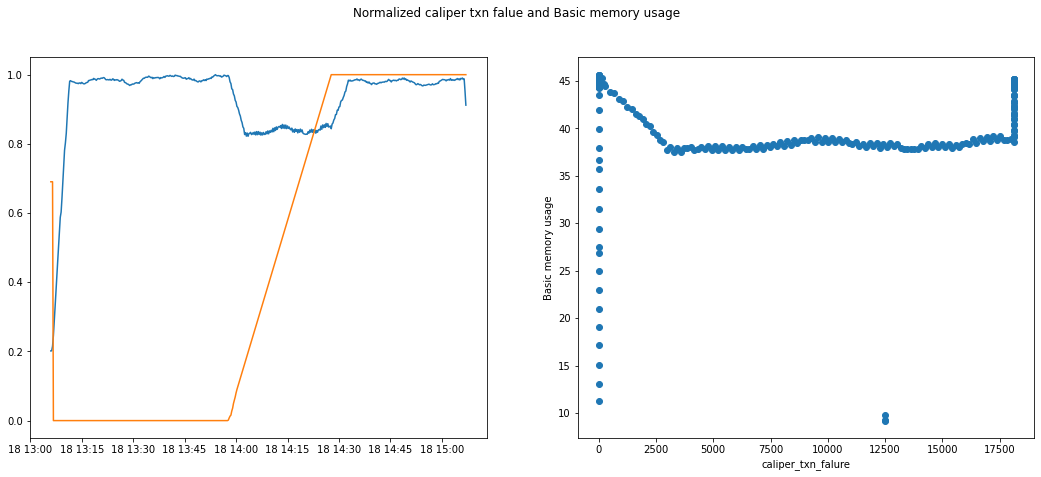

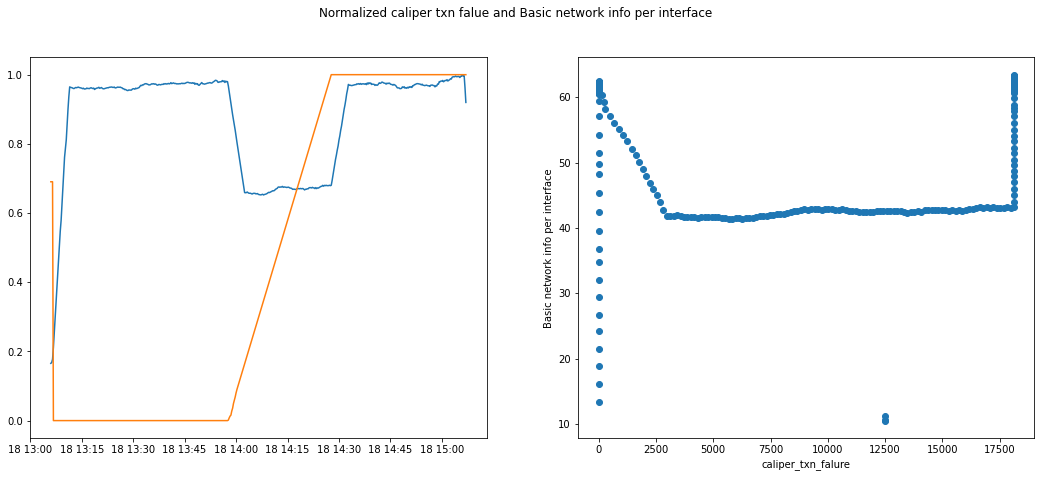

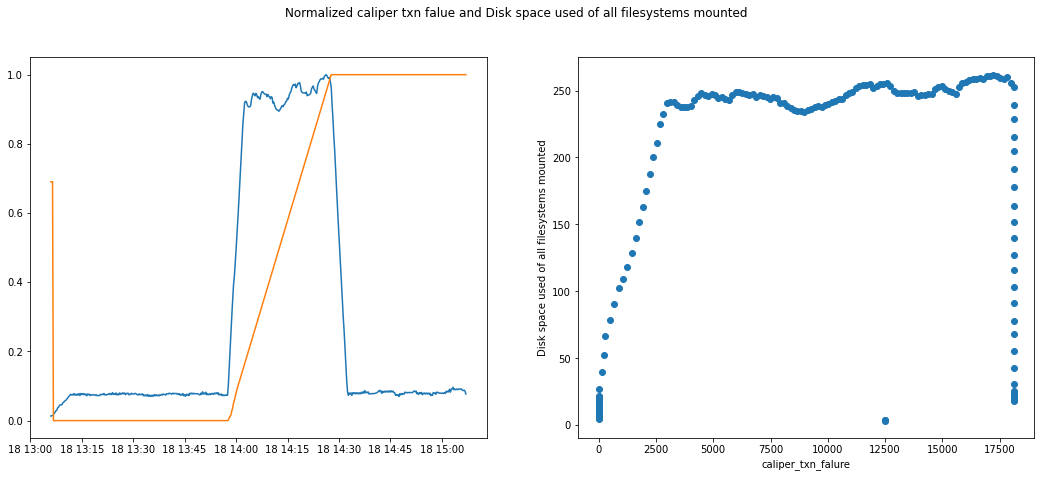

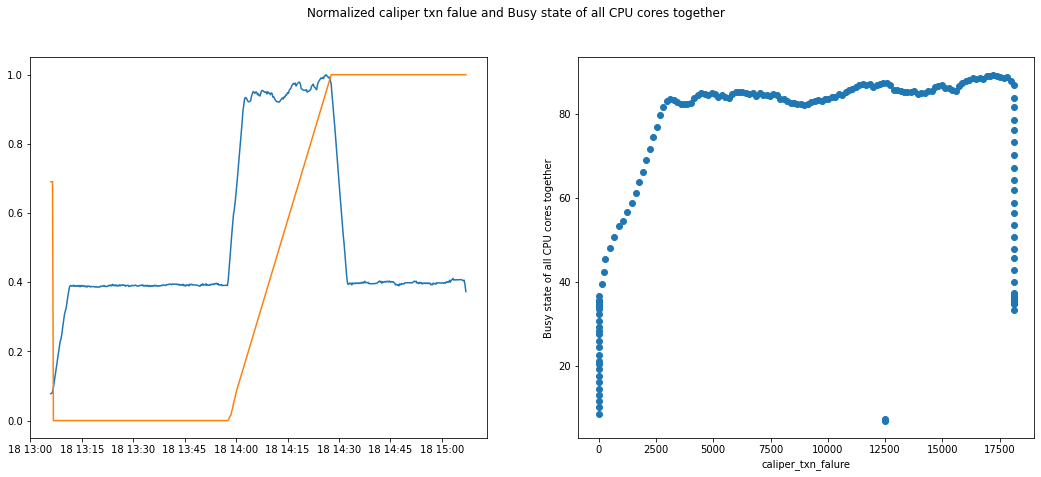

In [22]:
from sklearn.preprocessing import MinMaxScaler
normalized_label_data = label_data.copy()

for i in normalized_label_data.drop(['time'], axis=1).columns:  
    normalized_label_data[i]/=normalized_label_data[i].max()

for feature in selected_features_names:
    fig, ax =plt.subplots(figsize=(18,7))
    
    plt.subplot(1,2,1)
    plt.plot(normalized_label_data['time'], normalized_label_data[feature], label=feature)
    plt.plot(normalized_label_data['time'],normalized_label_data['caliper_txn_falure'],label='caliper_txn_falue')
    
    plt.subplot(1,2,2)
    plt.suptitle("Normalized caliper txn falue and "+feature)
    plt.scatter(label_data['caliper_txn_falure'], label_data[feature])
    plt.xlabel('caliper_txn_falure')
    plt.ylabel(feature)
#     plt.plot(normalized_label_data['time'],normalized_label_data['caliper_txn_falure'],label='caliper_txn_falue')
    plt.show()

# train test split

In [23]:
from sklearn.model_selection import train_test_split
# random state = 0 to preserve time series may change later. 
X_train,X_test, y_train, y_test = train_test_split(label_data.drop('label', axis=1), normalized_label_data.label, test_size=0.33, random_state=0)
# normalized_X_train,normalized_X_test, normalized_y_train, normalized_y_test = train_test_split(normalized_label_data.drop('label', axis=1), normalized_label_data.label, test_size=0.33, random_state=0)

y_train = y_train.to_frame()
y_train['time'] = X_train.time

X_train = X_train.reset_index()
y_train = y_train.reset_index()



# Isolation Forest

##### Isolation forest using most usefull metrics


In [24]:
to_model_columns=X_train.drop('time', axis=1).columns
df = label_data.drop(['time', 'label'], axis=1)

from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df)

pred = clf.predict(df)

# Predict on Train set inappropriate way 
df['IF predictions']=pred
outliers=X_train.loc[df['IF predictions']==-1]
outlier_index=list(outliers.index)
print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df['IF predictions'].value_counts())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 232, 234, 262, 264, 313]
 1    426
-1     59
Name: IF predictions, dtype: int64


# Plot isolation forest Outliers using PCA

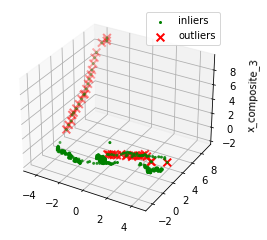

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

#normalize the metrics
X = scaler.fit_transform(df)
X_reduce = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

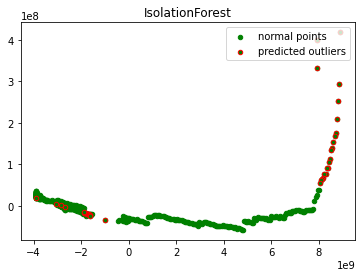

In [26]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df)
res=pd.DataFrame(pca.transform(df))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

#### plot predictions on Basic CPU info metric

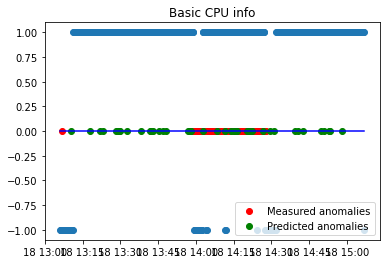

In [27]:
anomalies = [i for i,j in enumerate(label_data.label) if j]
anomalies

plt.scatter(label_data.time[anomalies], label_data['Basic CPU info'][anomalies], c='r', label='Measured anomalies')
plt.plot(label_data.time, label_data['Basic CPU info'], c='b')
plt.scatter(outliers.time, outliers['Basic CPU info'][outlier_index], c='g', label='Predicted anomalies')
plt.scatter(label_data.time, pred)
plt.title('Basic CPU info')
plt.legend()
plt.show()

In [28]:
# TODO accuracy, ROC, 


In [30]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

def plot_anomaly(df,metric_name):
    df.load_date = pd.to_datetime(df['load_date'].astype(str))
    dates = df.load_date
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "red"}
    
    #Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.3]),
        columnwidth=[1, 2],
        # columnorder=[0, 1, 2,],
        header=dict(height=20,
                    values=[['<b>Date</b>'], ['<b>Actual Values </b>'], ['<b>% Change </b>'],
                            ],
                    font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                    fill=dict(color='#d562be')),
        cells=dict(values=[df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'percentage_change']],
                   line=dict(color='#506784'),
                   align=['center'] * 5,
                   font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                   # format = [None] + [",.4f"] + [',.4f'],
                   # suffix=[None] * 4,
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   #fill=dict(color=[test_df['anomaly_class'].map(color_map)],#map based on anomaly level from dictionary
                   #)
                   ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=df['actuals'],
                         xaxis='x1', yaxis='y1',
                         mode='lines',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))
    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
    axis = dict(
            showline=True,
            zeroline=False,
            showgrid=True,
            mirror=True,
            ticklen=4,
            gridcolor='#ffffff',
            tickfont=dict(size=10))
    layout = dict(
            width=1000,
            height=865,
            autosize=False,
            title=metric_name,
            margin=dict(t=75),
            showlegend=True,
            xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
            yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
    pyplot.show()

In [31]:
def classify_anomalies(df,metric_name):
    df['metric_name']=metric_name
    df = df.sort_values(by='load_date', ascending=False)
    #Shift actuals by one timestamp to find the percentage chage between current and previous data point
    df['shift'] = df['actuals'].shift(-1)
    df['percentage_change'] = ((df['actuals'] - df['shift']) / df['actuals']) * 100
    #Categorise anomalies as 0-no anomaly, 1- low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df

In [32]:
import warnings  
metrics_df = label_data
# metrics_df['time'] = label_data['time']

warnings.filterwarnings('ignore')
for i in range(1,len(metrics_df.columns)-1):
    clf.fit(metrics_df.iloc[:,i:i+1])
    pred = clf.predict(metrics_df.iloc[:,i:i+1])
    test_df=pd.DataFrame()
    test_df['load_date']=metrics_df['time']
    #Find decision function to find the score and classify anomalies
    test_df['score']=clf.decision_function(metrics_df.iloc[:,i:i+1])
    test_df['actuals']=metrics_df.iloc[:,i:i+1]
    test_df['anomaly']=pred
    #Get the indexes of outliers in order to compare the metrics     with use case anomalies if required
    outliers=test_df.loc[test_df['anomaly']==-1]
    outlier_index=list(outliers.index)
    test_df=classify_anomalies(test_df,metrics_df.columns[i])
    plot_anomaly(test_df,metrics_df.columns[i])

# K-Means

In [275]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
    
def cluster(data):
    data = pd.DataFrame(data)
    clf = KMeans(n_clusters=2)
    clf.fit(data)
    
    # always classify anomaly as 1
    labels = clf.labels_
    one_counts = list(labels).count(1)
    zero_counts = list(labels).count(0)
    
#     if one_counts > zero_counts:
# #         print(labels)
#         labels = [not i for i in labels]
#         labels = map(int, labels)
#         print(labels)
    
    return labels

def plot_kmeans(df, predictions, column):
    
#     predictions = pd.DataFrame(predictions, columns = ['predictions'])
    df_copy = df.copy()
    df_copy['predictions'] = predictions

    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df_copy['predictions'] == 1, ['time', column]] #anomaly
    b = df.loc[df_copy['label'] == 1, ['time',column]] #anomaly
    ax.plot(df_copy['time'], df_copy[column], color='blue')

    ax.scatter(b['time'],b[column], color='green', label='Measured anomaly')
    ax.scatter(a['time'],a[column], color='red', label='Predicted Anomaly')
    plt.xlabel('Date Time Integer')
    plt.ylabel(column)

    plt.legend()
    plt.show()
    return df_copy
    
def evaluate(df):
    # Evaluation
    
    # accuracy
    true_label = df['label']
    pred_label = df['predictions']
    accuracy = accuracy_score(true_label,pred_label)
    print('Accuracy: ', accuracy)
    # precision
    precision = precision_score(true_label, pred_label, average='macro')
    print('Precision: ', precision)
    # recall
    recall = metrics.recall_score(true_label, pred_label, average='macro')
    print('Recall: ', recall)
    f1_score = metrics.f1_score(true_label, pred_label, average='macro') 
    print('F1 score: ', f1_score)

    # AUC curve
    fpr, tpr, threshold = metrics.roc_curve(true_label, pred_label)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


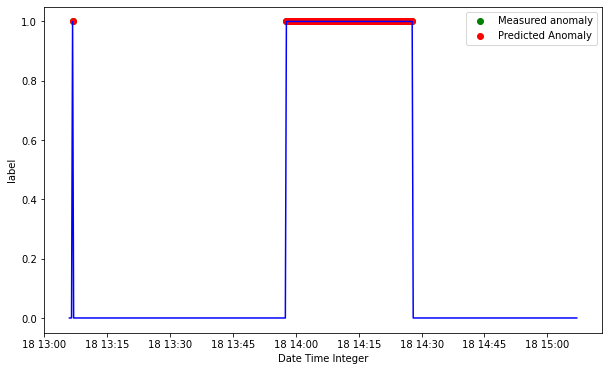

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0


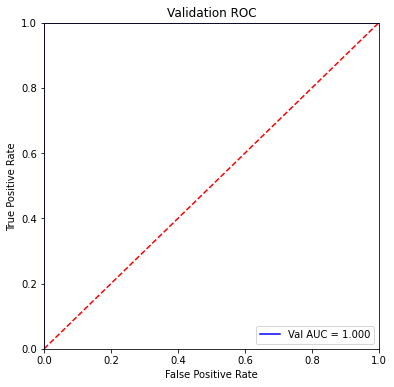

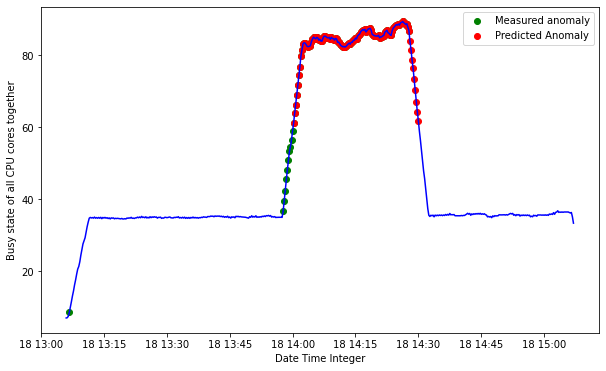

Accuracy:  0.9587628865979382
Precision:  0.9474315068493151
Recall:  0.9425213385720093
F1 score:  0.9449414222141495


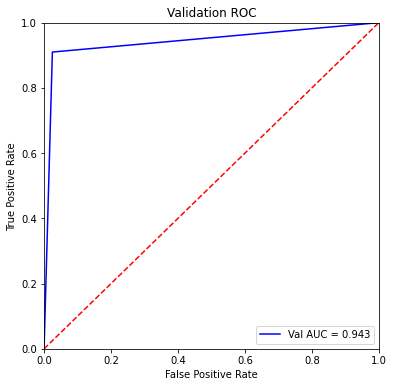

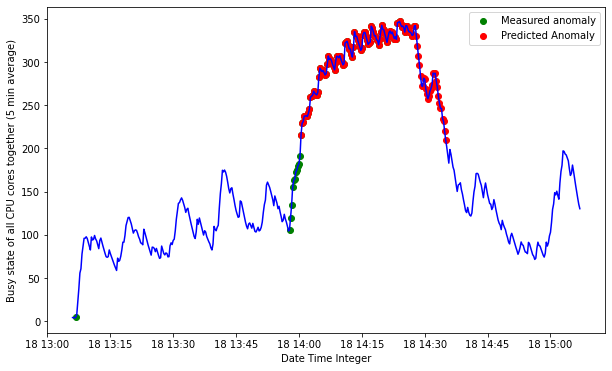

Accuracy:  0.9154639175257732
Precision:  0.8783424127749824
Recall:  0.9108747685498804
F1 score:  0.8925419753686862


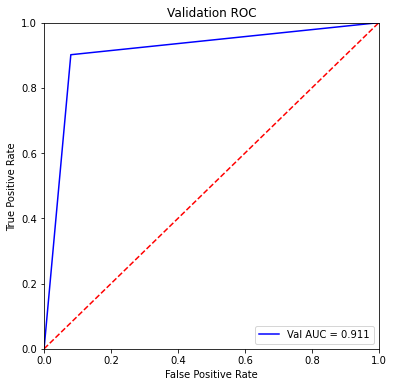

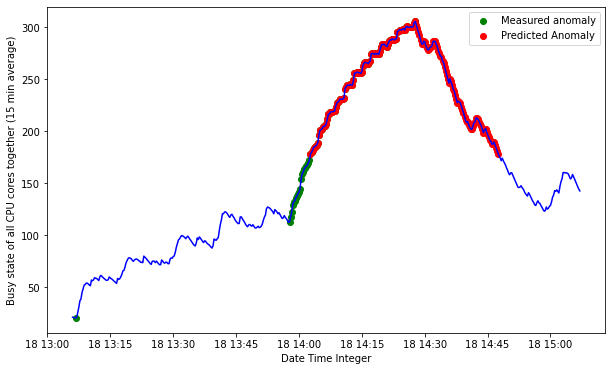

Accuracy:  0.7938144329896907
Precision:  0.7461293260473588
Recall:  0.805118999232263
F1 score:  0.7595867866915176


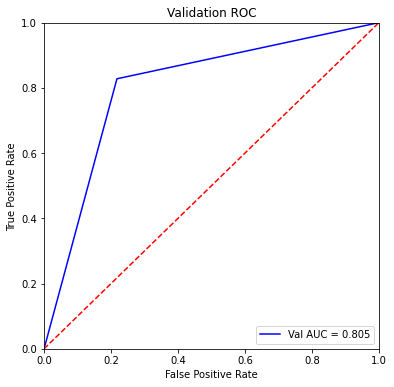

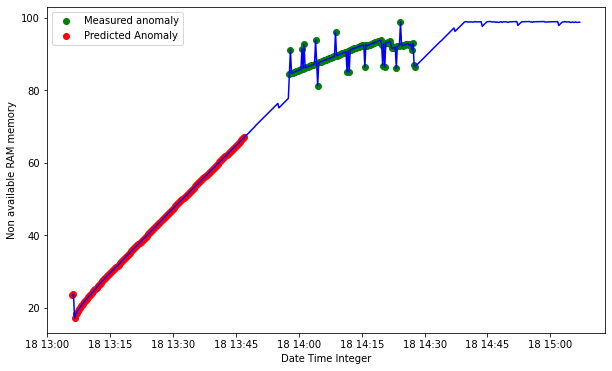

Accuracy:  0.41237113402061853
Precision:  0.313967803030303
Recall:  0.27820304385133
F1 score:  0.2948459603817958


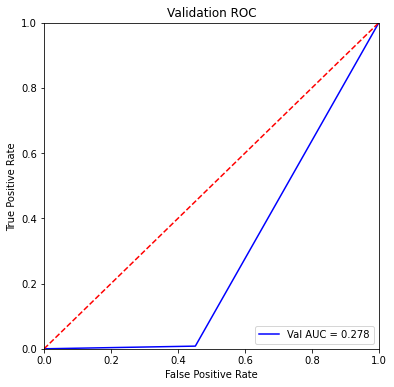

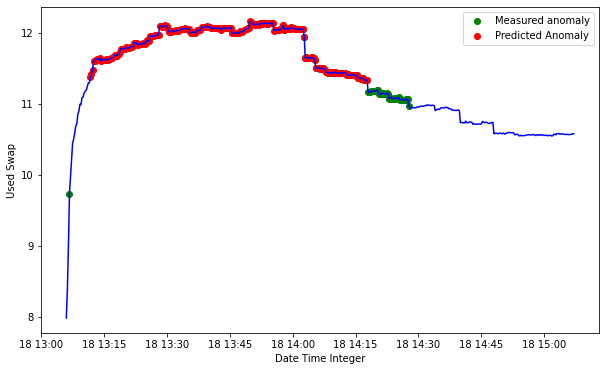

Accuracy:  0.5360824742268041
Precision:  0.5596483704974271
Recall:  0.5785236869439552
F1 score:  0.5163349156328533


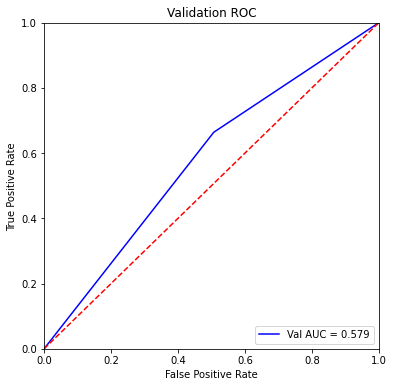

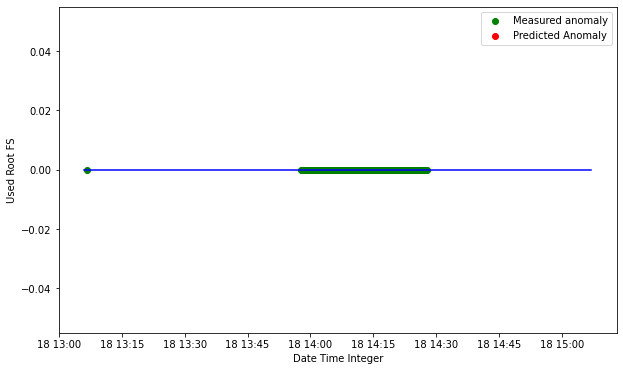

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


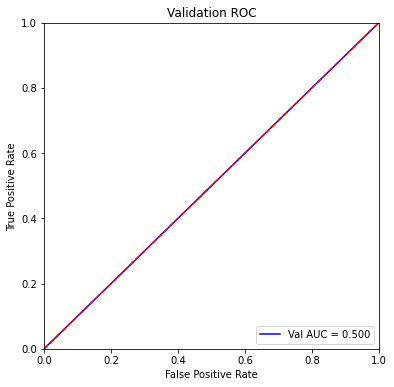

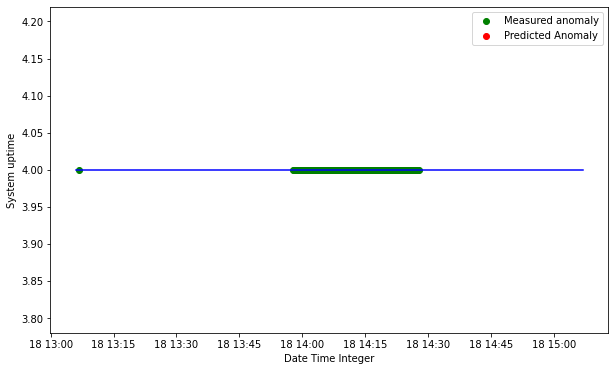

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


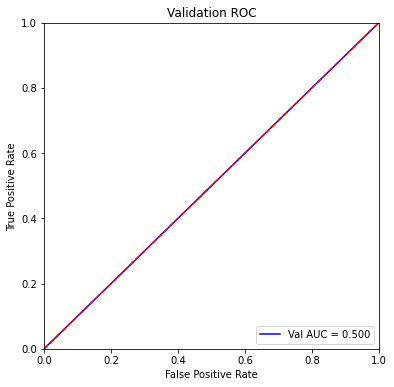

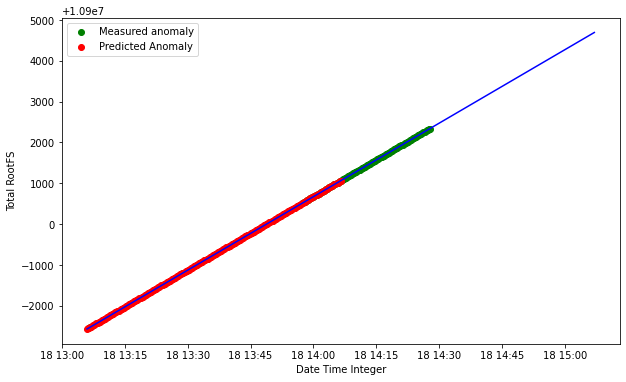

Accuracy:  0.4
Precision:  0.4005118525320545
Recall:  0.3678927877884659
F1 score:  0.3608739952451036


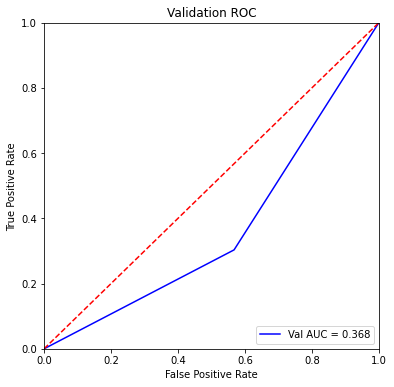

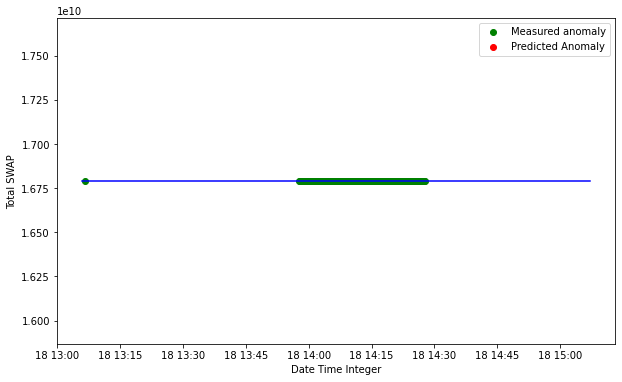

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


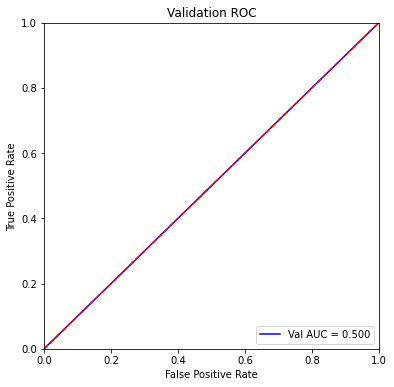

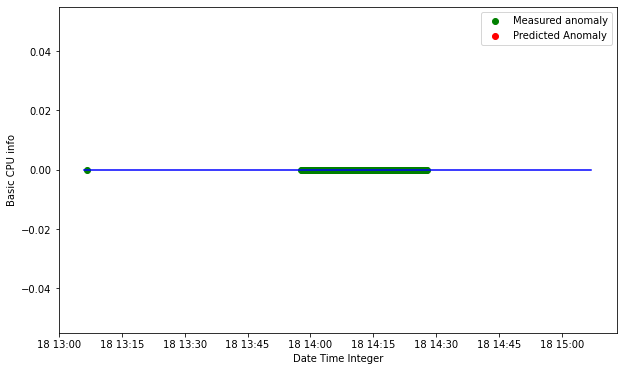

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


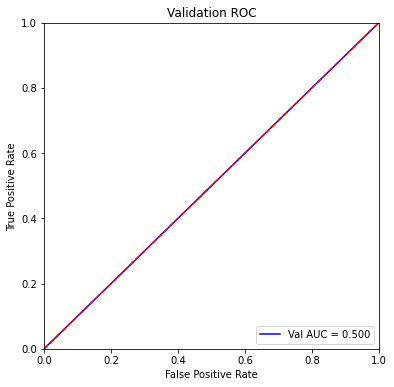

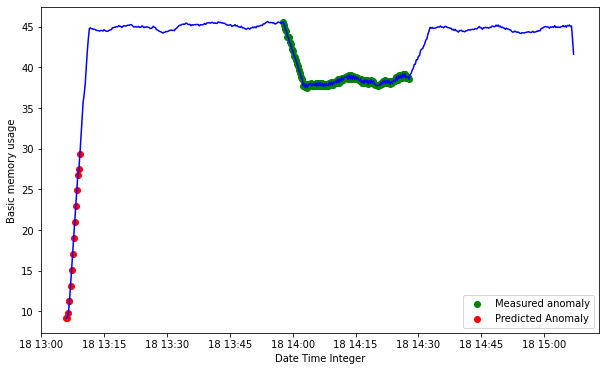

Accuracy:  0.7237113402061855
Precision:  0.40726417955717314
Recall:  0.4861920245675834
F1 score:  0.4270172097616024


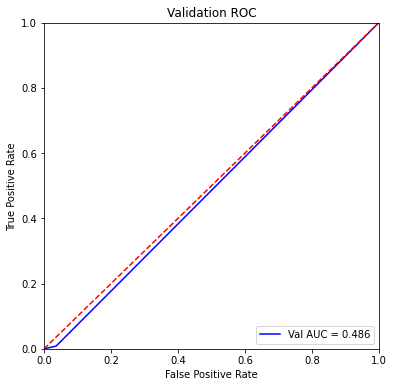

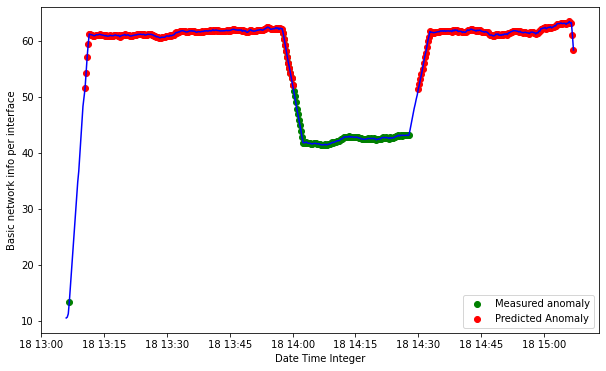

Accuracy:  0.07216494845360824
Precision:  0.10560869200436278
Recall:  0.07541886826536603
F1 score:  0.07127659574468084


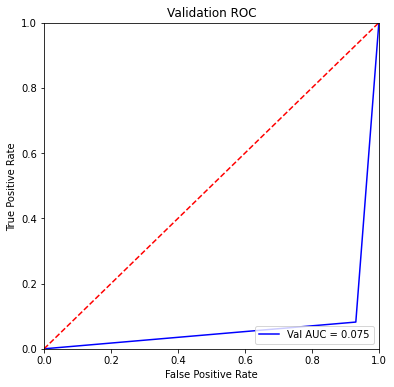

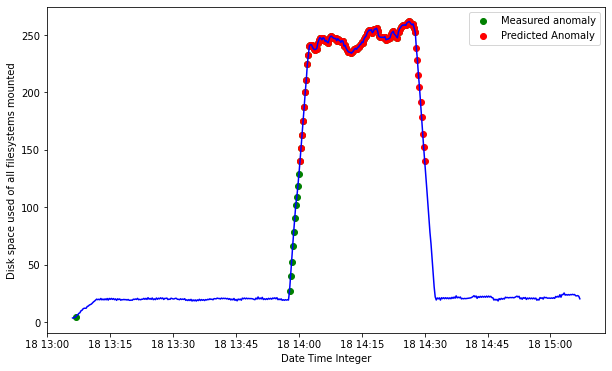

Accuracy:  0.9587628865979382
Precision:  0.9474315068493151
Recall:  0.9425213385720093
F1 score:  0.9449414222141495


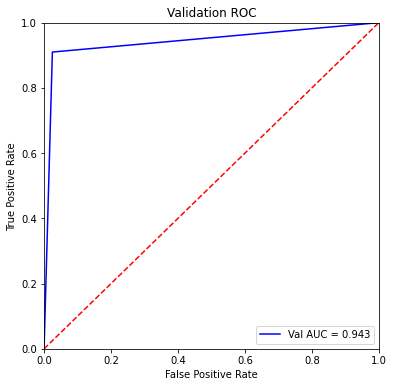

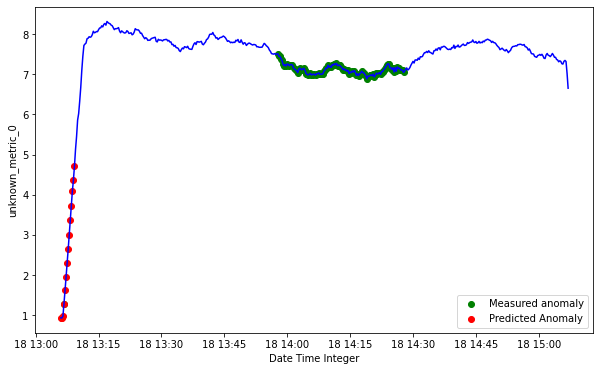

Accuracy:  0.7237113402061855
Precision:  0.40726417955717314
Recall:  0.4861920245675834
F1 score:  0.4270172097616024


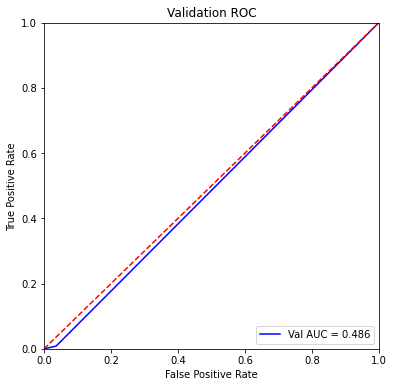

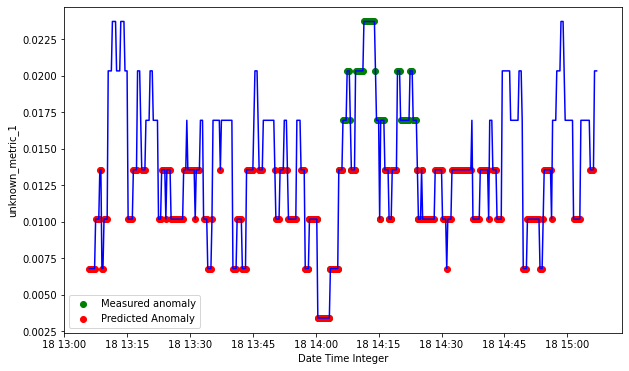

Accuracy:  0.42061855670103093
Precision:  0.4731489741302409
Recall:  0.46601634828162397
F1 score:  0.40900082827047585


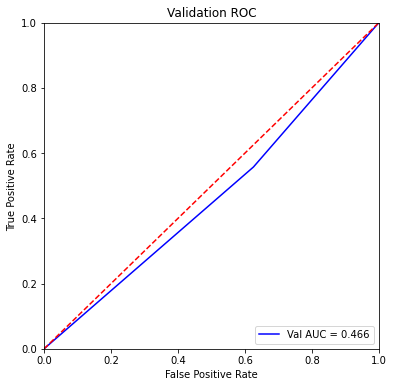

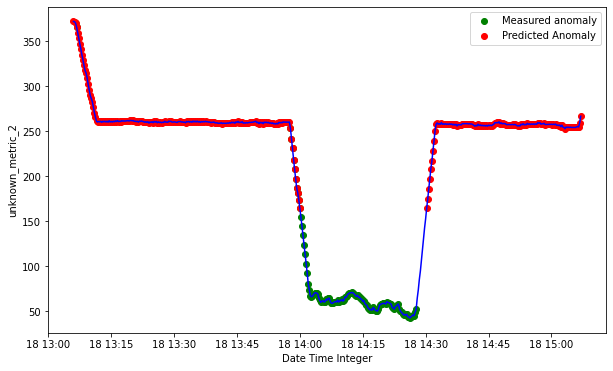

Accuracy:  0.041237113402061855
Precision:  0.05256849315068493
Recall:  0.05747866142799079
F1 score:  0.041220809366510645


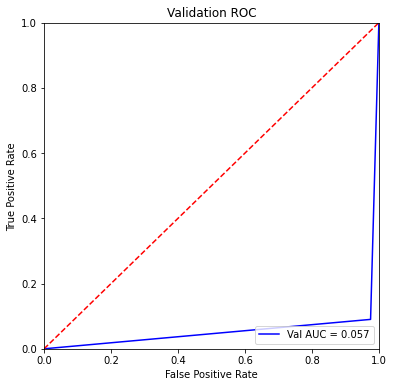

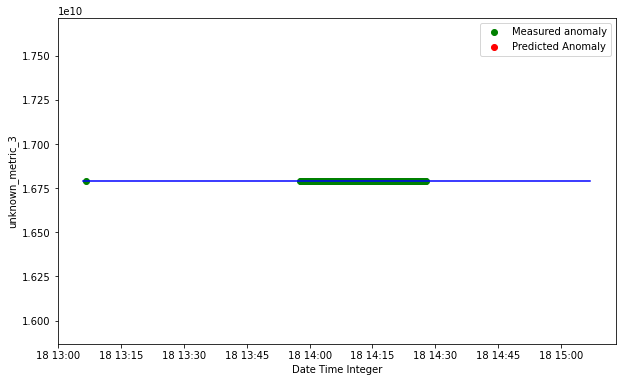

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


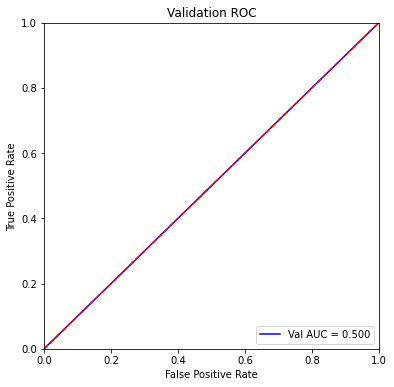

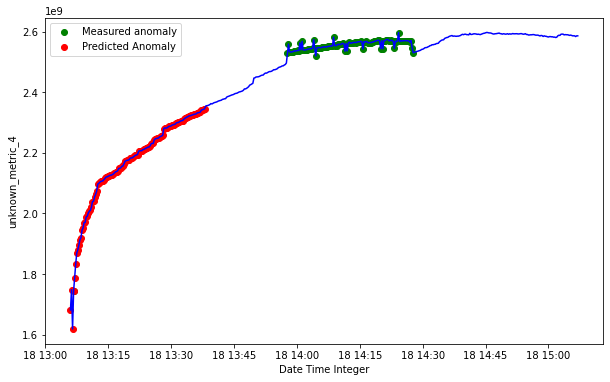

Accuracy:  0.4865979381443299
Precision:  0.33393214876752897
Recall:  0.3277898207108341
F1 score:  0.3308269010190116


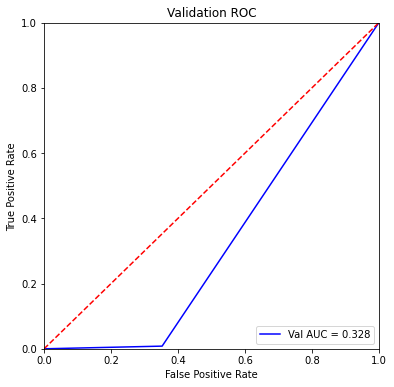

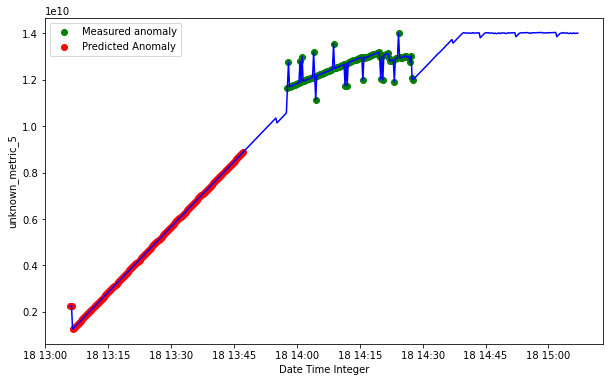

Accuracy:  0.41030927835051545
Precision:  0.313356875778978
Recall:  0.2768256333830104
F1 score:  0.2937948028673835


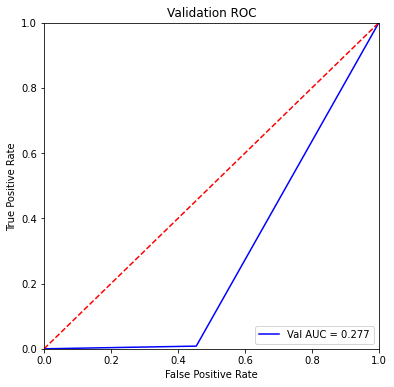

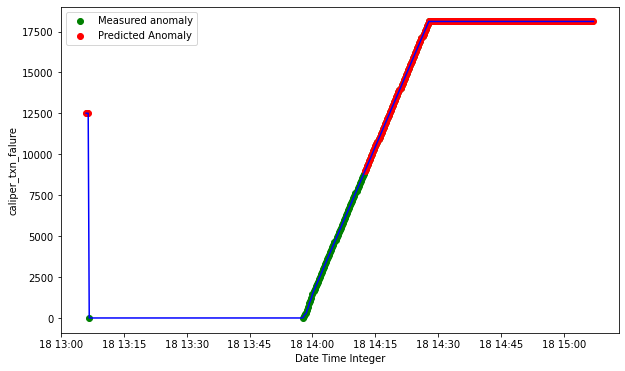

Accuracy:  0.5463917525773195
Precision:  0.5255711985750009
Recall:  0.5337126857246082
F1 score:  0.5045137082992793


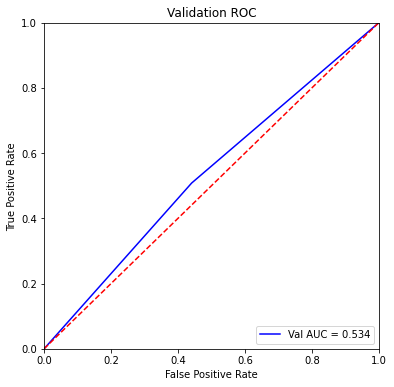

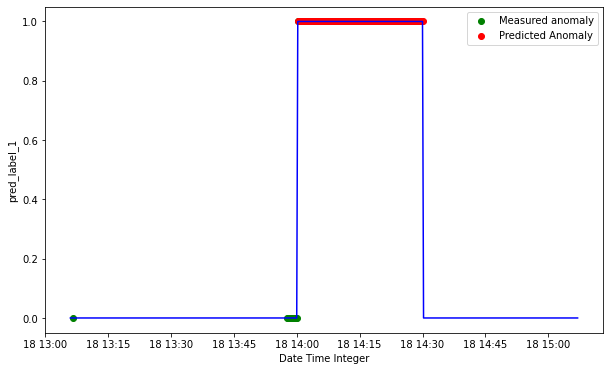

Accuracy:  0.9587628865979382
Precision:  0.9474315068493151
Recall:  0.9425213385720093
F1 score:  0.9449414222141495


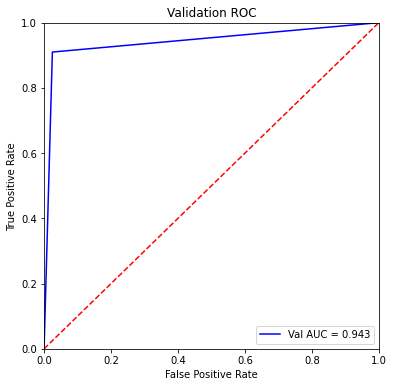

In [276]:
for label in label_data.columns:
    try:
        predictions = cluster(label_data[label])
        res =  plot_kmeans(label_data, predictions, label)
        evaluate(res)
    except:
        pass

<p style="color:red;">Sometimes binary classification should be the opposite -> 1 should be 0 and 0 should be 1. </p>

# DBSCAN

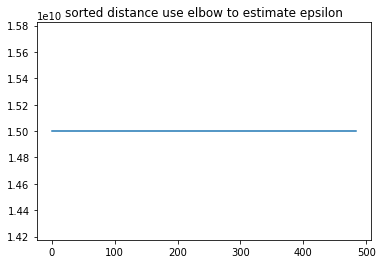

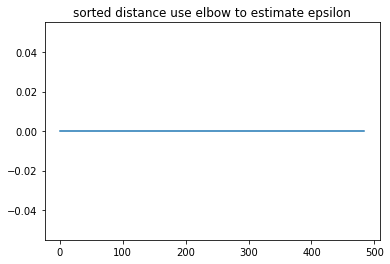

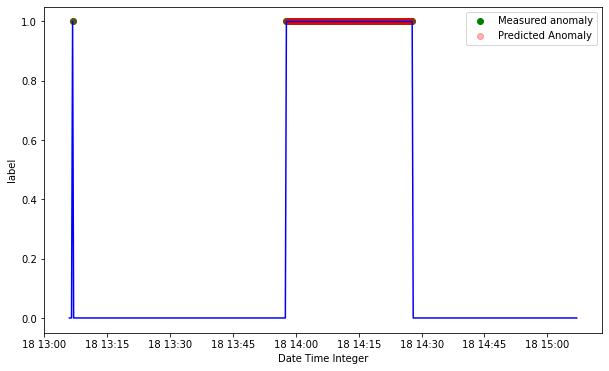

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0


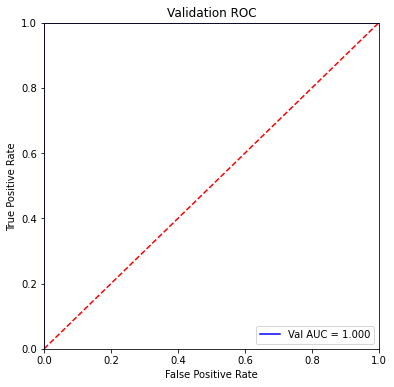

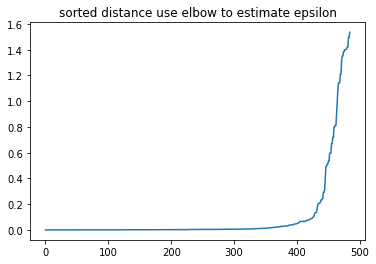

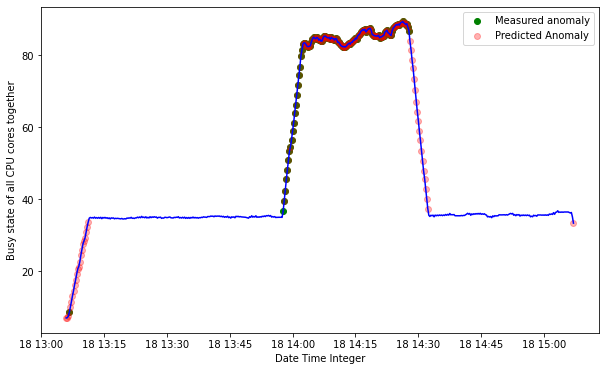

Accuracy:  0.9154639175257732
Precision:  0.8742331876389847
Recall:  0.9408052206114799
F1 score:  0.8977219539041564


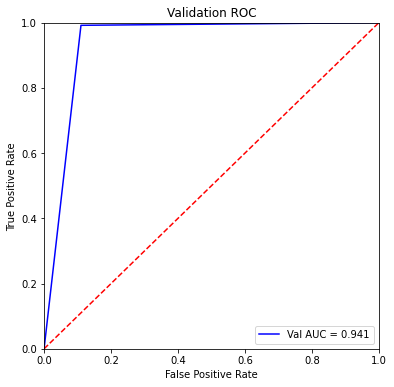

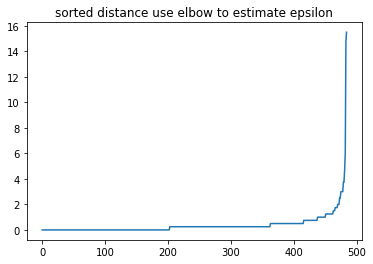

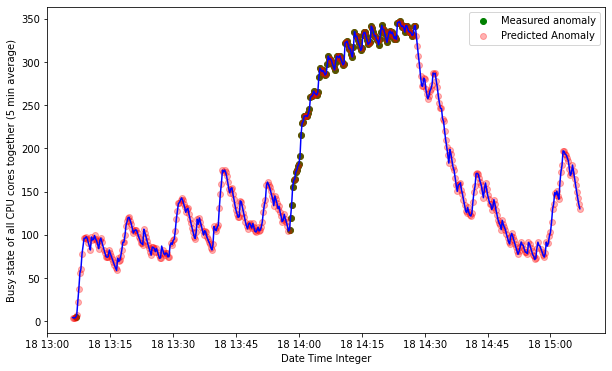

Accuracy:  0.27010309278350514
Precision:  0.6281512605042017
Recall:  0.512396694214876
F1 score:  0.22820692631351816


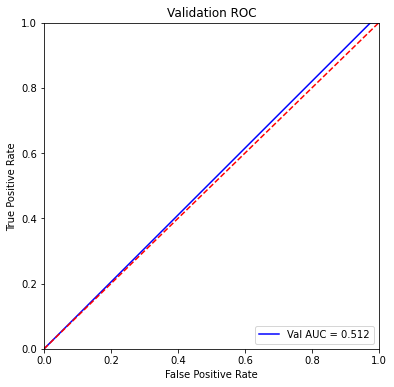

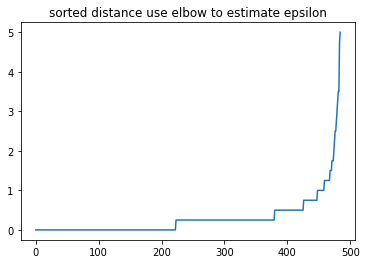

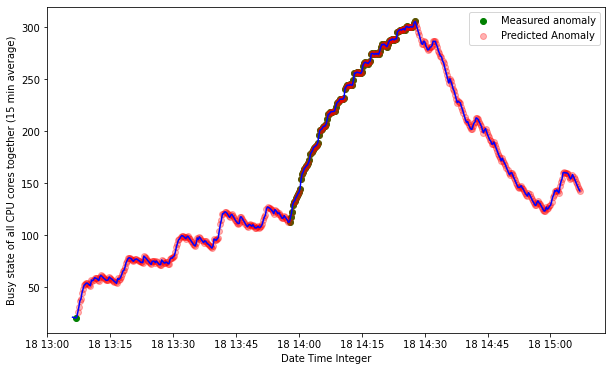

Accuracy:  0.25773195876288657
Precision:  0.5260416666666667
Recall:  0.5014112812175405
F1 score:  0.2118662429582551


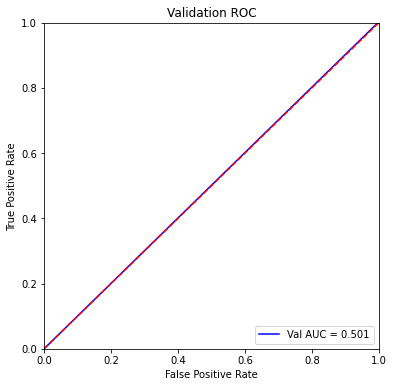

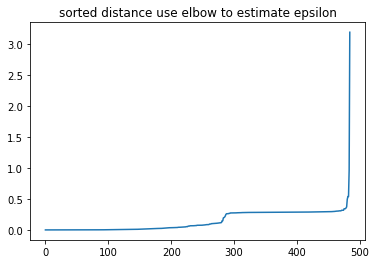

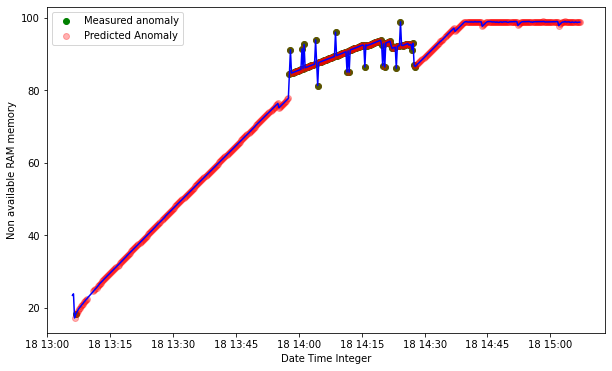

Accuracy:  0.26597938144329897
Precision:  0.6276150627615062
Recall:  0.509641873278237
F1 score:  0.22225225225225226


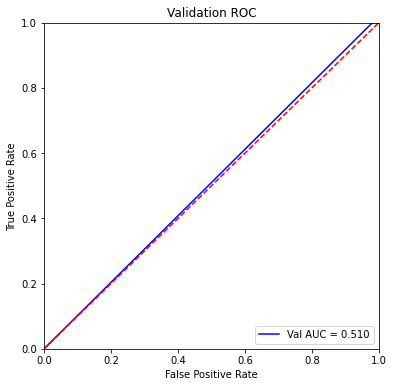

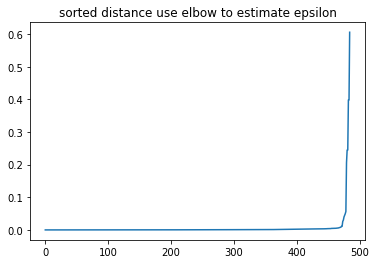

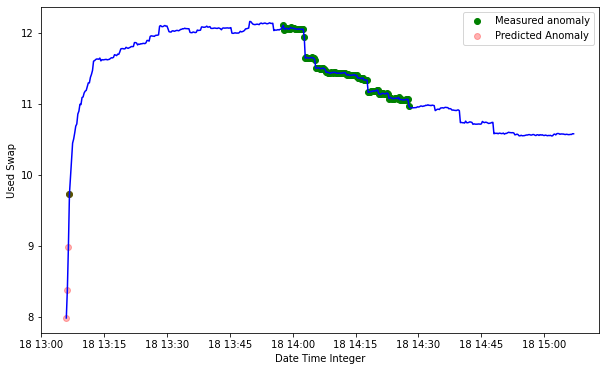

Accuracy:  0.7443298969072165
Precision:  0.49922037422037424
Recall:  0.49996612925077905
F1 score:  0.43447679229669756


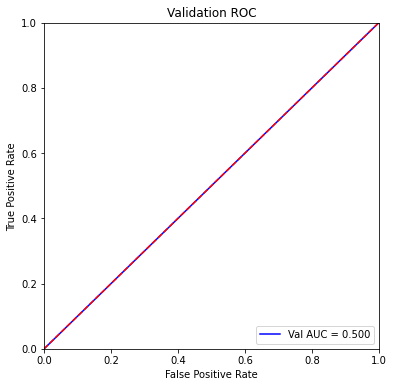

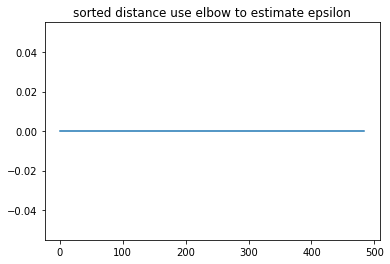

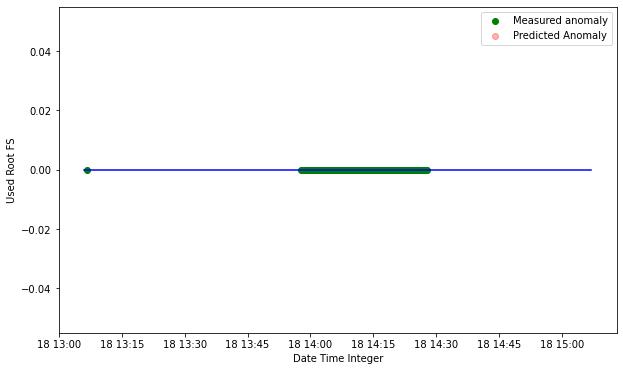

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


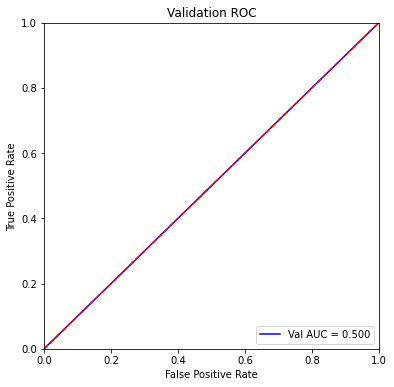

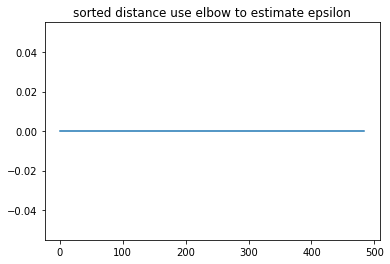

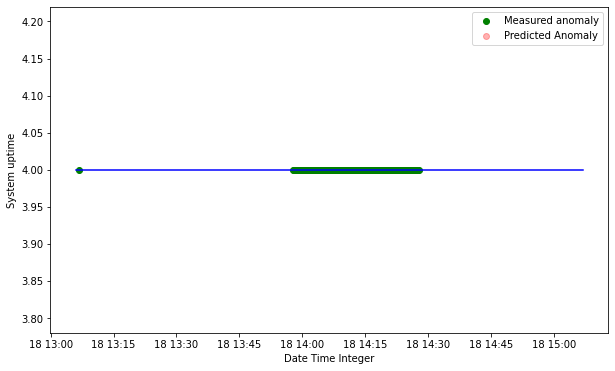

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


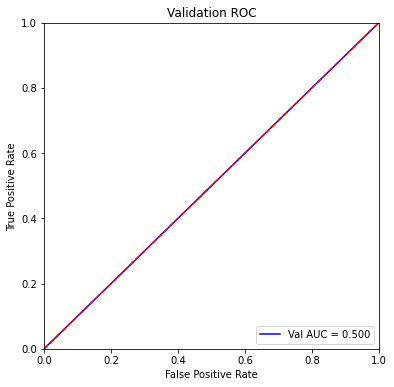

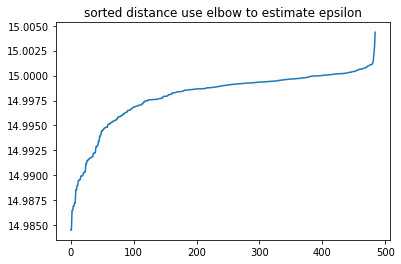

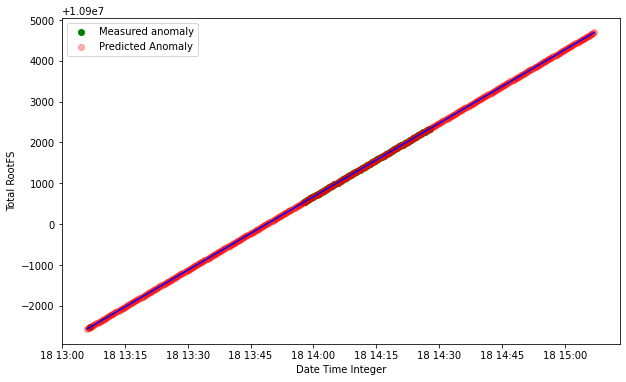

Accuracy:  0.2515463917525773
Precision:  0.12577319587628866
Recall:  0.5
F1 score:  0.20098846787479407


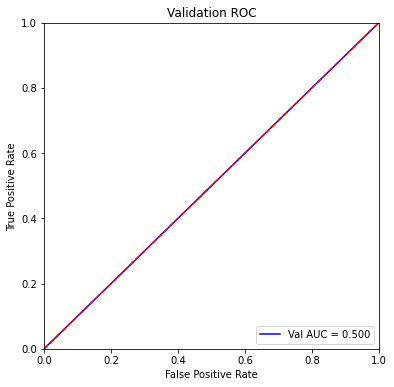

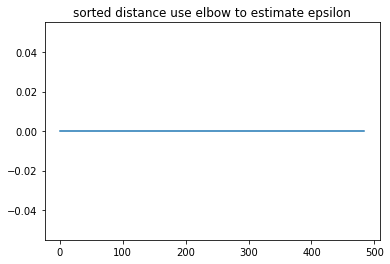

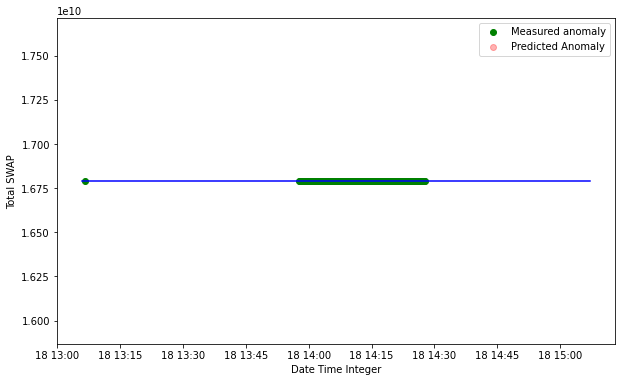

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


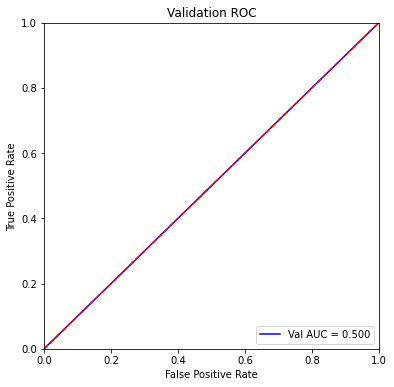

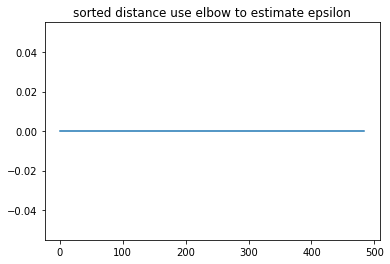

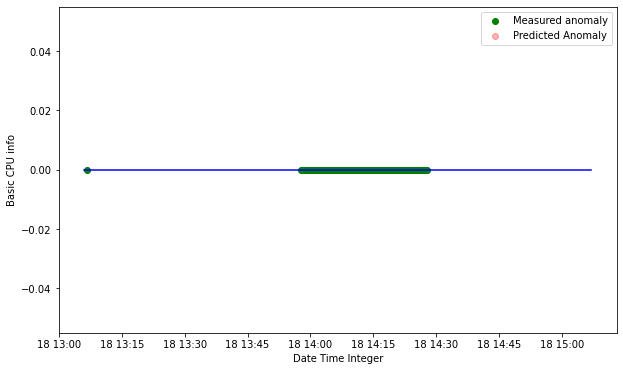

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


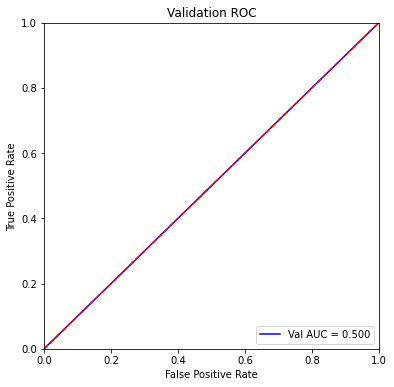

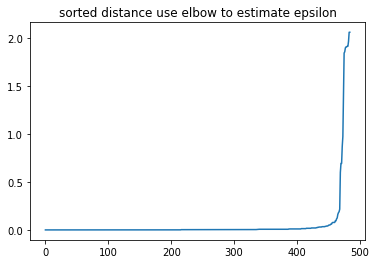

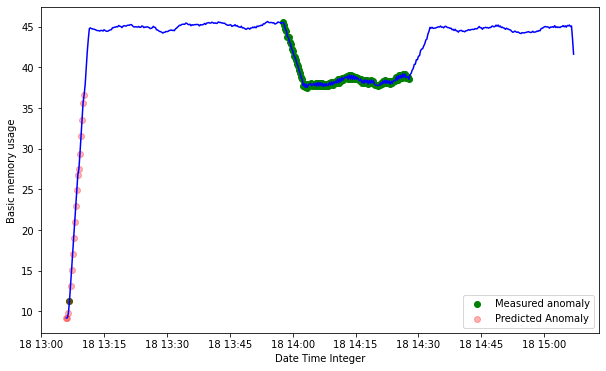

Accuracy:  0.7154639175257732
Precision:  0.39822745657863434
Recall:  0.4806823826943052
F1 score:  0.42401032702237523


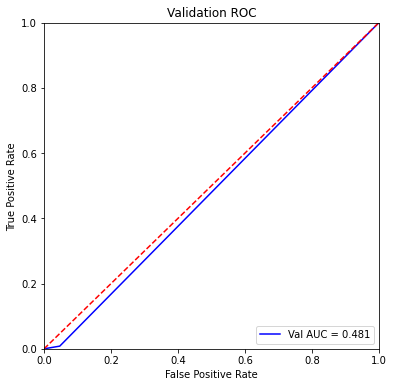

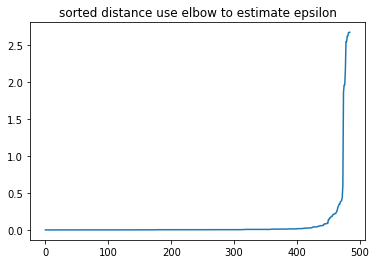

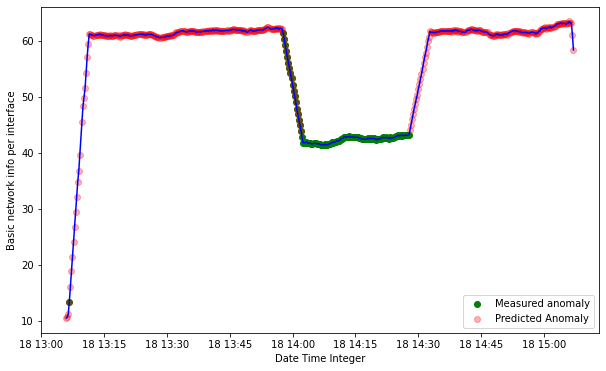

Accuracy:  0.041237113402061855
Precision:  0.029742075509792045
Recall:  0.07924626292733596
F1 score:  0.03991468746408062


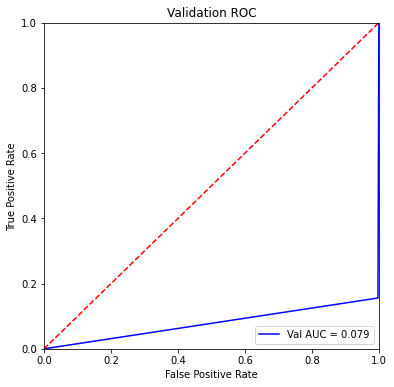

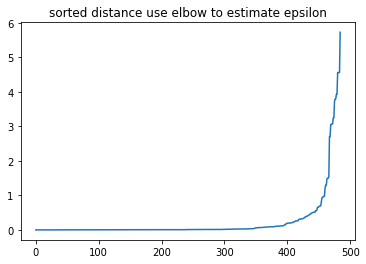

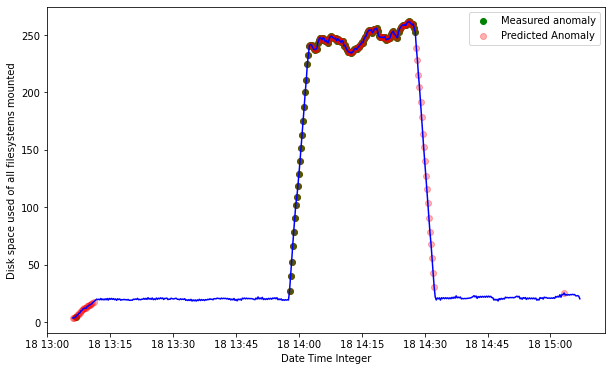

Accuracy:  0.9195876288659793
Precision:  0.8788819875776397
Recall:  0.9462809917355373
F1 score:  0.9027111268844414


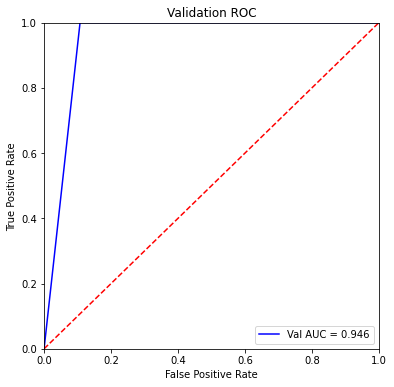

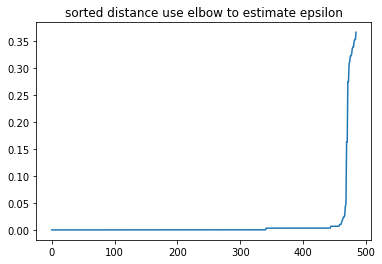

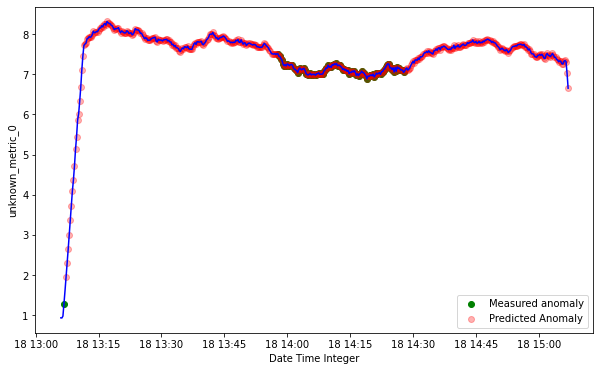

Accuracy:  0.25773195876288657
Precision:  0.5260416666666667
Recall:  0.5014112812175405
F1 score:  0.2118662429582551


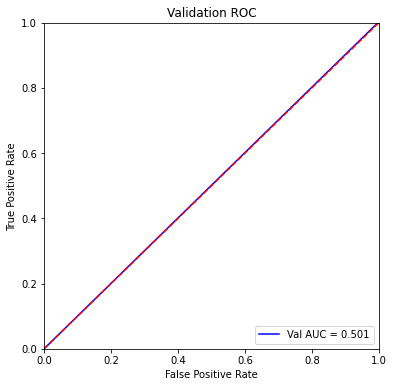

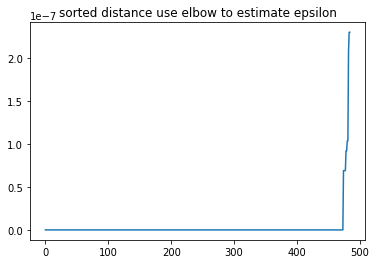

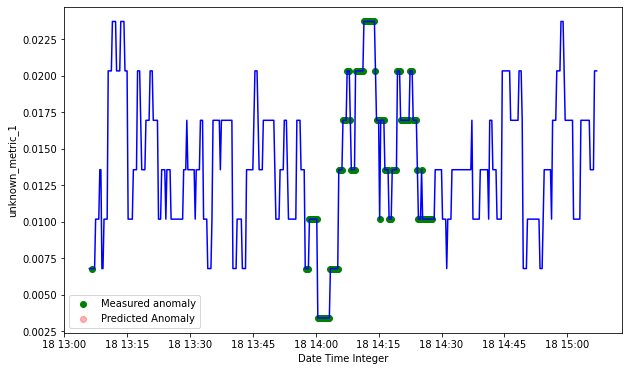

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


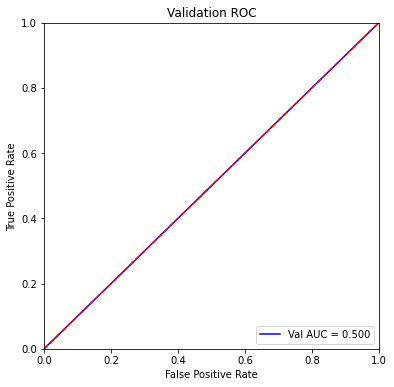

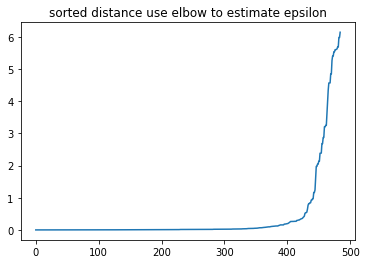

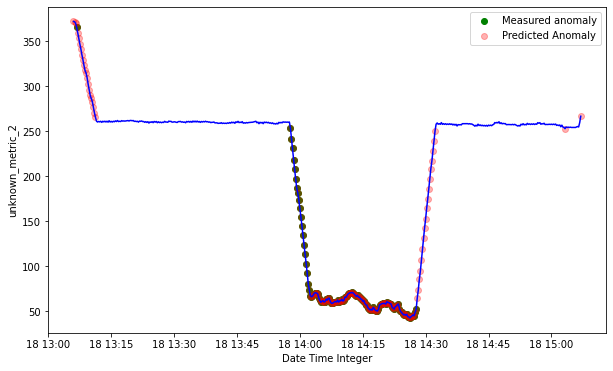

Accuracy:  0.9154639175257732
Precision:  0.8742331288343559
Recall:  0.943526170798898
F1 score:  0.8981431681393264


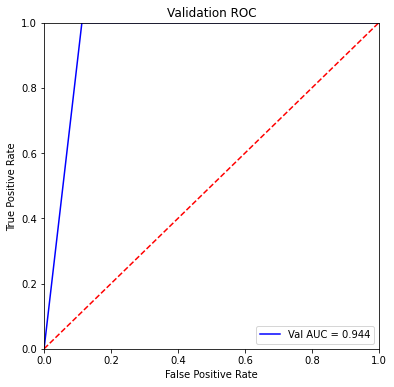

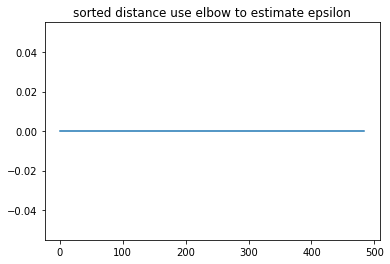

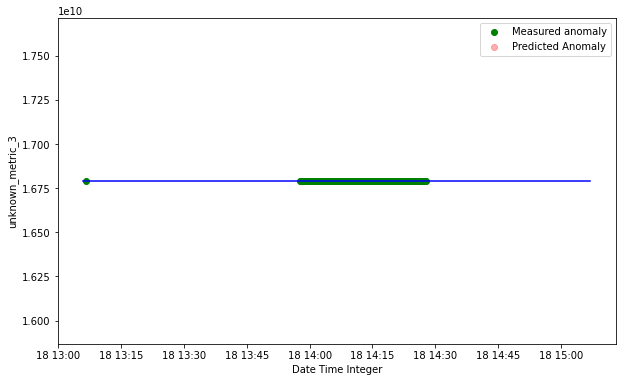

Accuracy:  0.7484536082474227
Precision:  0.37422680412371134
Recall:  0.5
F1 score:  0.42806603773584906


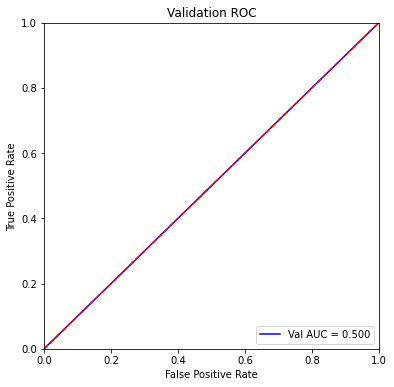

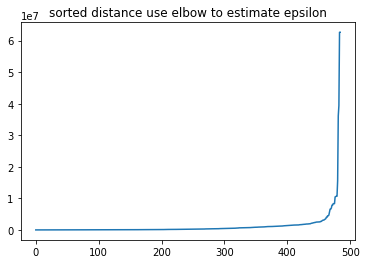

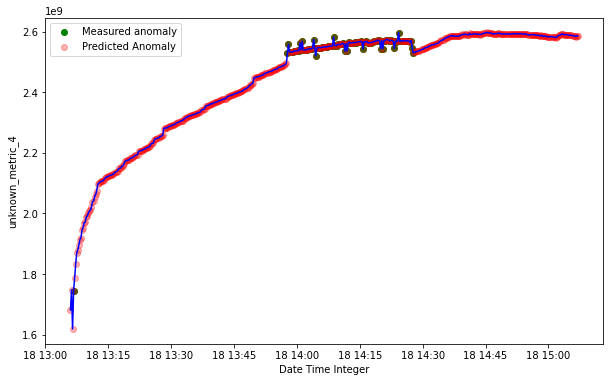

Accuracy:  0.2515463917525773
Precision:  0.12577319587628866
Recall:  0.5
F1 score:  0.20098846787479407


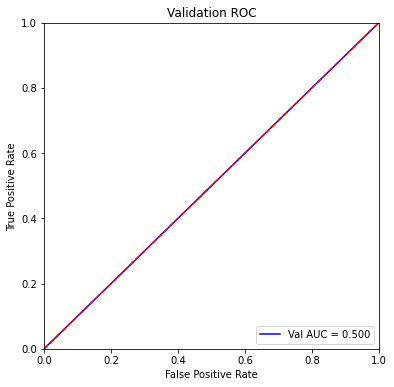

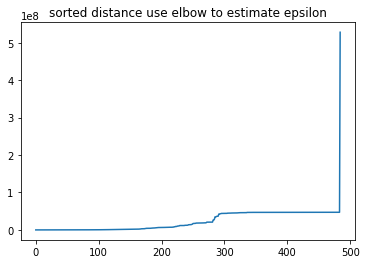

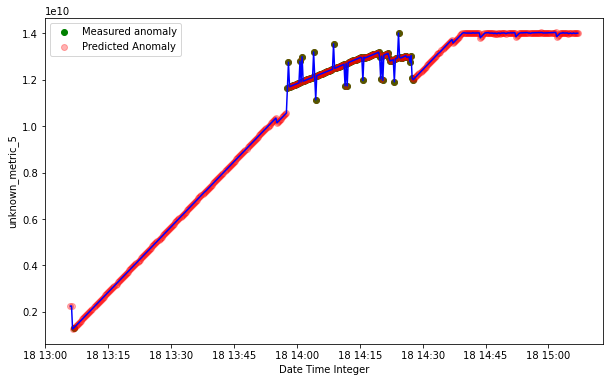

Accuracy:  0.2515463917525773
Precision:  0.12577319587628866
Recall:  0.5
F1 score:  0.20098846787479407


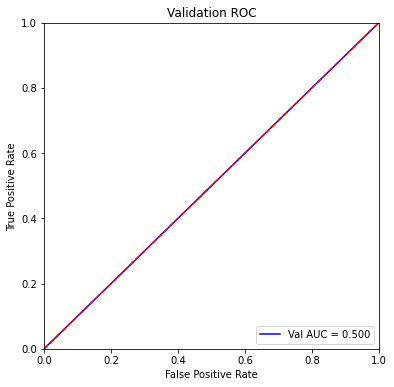

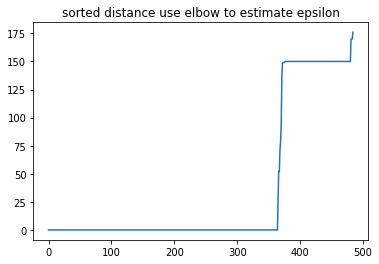

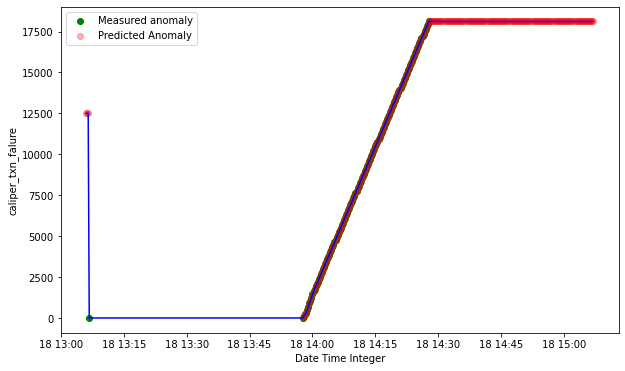

Accuracy:  0.668041237113402
Precision:  0.712851510711046
Recall:  0.7755159644131329
F1 score:  0.658272830315841


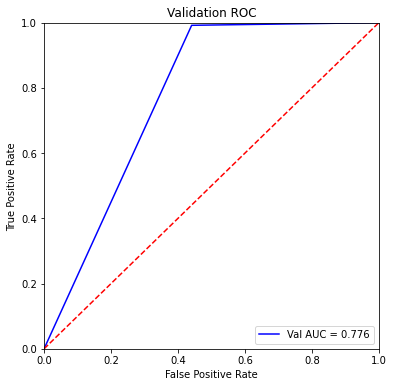

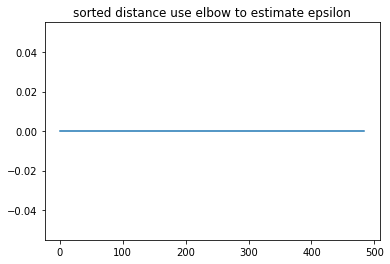

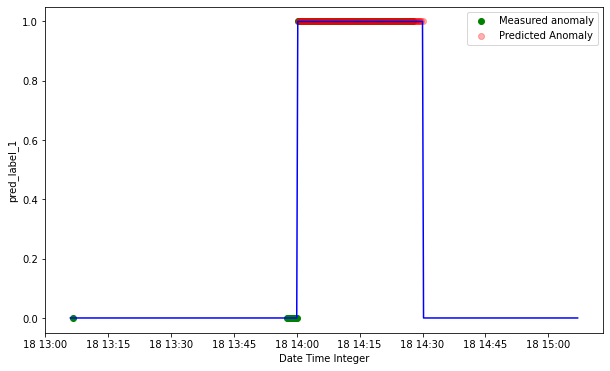

Accuracy:  0.9587628865979382
Precision:  0.9474315068493151
Recall:  0.9425213385720093
F1 score:  0.9449414222141495


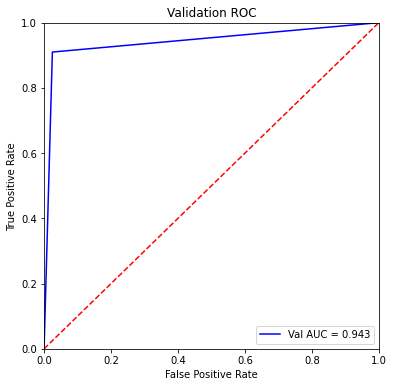

In [302]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

#TODO make df with all results

def nn(df):
    neighbors = NearestNeighbors(n_neighbors=20)
    neighbors_fit = neighbors.fit(df)
    distances, indices = neighbors_fit.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.title('sorted distance use elbow to estimate epsilon')
    plt.plot(distances)
    plt.show()
    
def dbscan(df, column):
    df_copy = df.copy()
    clustering = DBSCAN().fit(np.array(df_copy[column]).reshape(1,-1).T)
    df_copy['predictions'] = pd.Series(clustering.labels_.astype(bool).astype(int))
    return df_copy

def plot_dbscan(df, feature):
    
    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df['predictions'] == 1, ['time', feature]] #classified anomaly
    b = df.loc[df['label'] == 1, ['time',feature]] #measured anomaly
    
    ax.scatter(b['time'],b[feature], color='green', label='Measured anomaly', alpha=1)
    ax.scatter(a['time'],a[feature], color='red', label='Predicted Anomaly', alpha=0.3)
    ax.plot(df['time'], df[feature], color='blue')
    plt.xlabel('Date Time Integer')
    plt.ylabel(feature)
    plt.legend()
    plt.show()


for label in label_data.columns:
    try:
        nn(np.array(label_data[label]).reshape(1,-1).T)
        db_res = dbscan(label_data, label)
        plot_dbscan(db_res, label)
        evaluate(db_res)
    except:
        pass


# SUPERVISED METHODS

# KNN

In [334]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier

#TODO make categorical features
def knn(X_train, Y_train, X_test):
    model = KNeighborsClassifier(n_neighbors=2)
    model.fit(X_train, Y_train)
    return model.score(X_test, Y_test), model.predict(X_test)



In [335]:
# db_res = dbscan(label_data, label)
# from sklearn.model_selection import train_test_split

# feature = label_data.columns[3]

# X_train, X_test, Y_train, Y_test = train_test_split(np.array(label_data[feature]), np.array(label_data[feature]), test_size=0.2, random_state=22)

# knn(X_train.reshape(1,-1).T, Y_train.reshape(1,-1).T, X_test)
# plot_dbscan(db_res, label)
# evaluate(db_res)


In [336]:
# TODO combine features

# SVM

In [338]:
import time
from sklearn.svm import OneClassSVM
df = label_data
data = df_features
#scaler = StandardScaler()
#np_scaled = scaler.fit_transform(data)
#data = pd.DataFrame(np_scaled)
# train oneclassSVM 
print(time.time())
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
print(time.time())
df['anomaly_isoltree'] = pd.Series(model.predict(data))
print(df)
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_isoltree'] == -1, ['time', 'disk_iops']] #anomaly
b = df.loc[df['label'] == 1, ['time', 'disk_iops']] #anomaly
ax.plot(df['time'], df['disk_iops'], color='blue')
ax.scatter(a['time'],a['disk_iops'], color='red', label='Anomaly')
ax.scatter(b['time'],b['disk_iops'], color='green', label='Normal')
plt.legend()
plt.show()

1622458995.5946345


NameError: name 'outliers_fraction' is not defined

# RF